In [7]:
import cv2
from ultralytics import YOLO
# Load mô hình
model = YOLO("./models/yolo-11-biensoxe.pt")

import cv2

def resize_image_if_larger(image_path, target_width=500):
    img = cv2.imread(image_path)

    if img is None:
        print(f"Không thể đọc ảnh từ đường dẫn: {image_path}")
        return None

    height, width = img.shape[:2]

    if width > target_width:
        aspect_ratio = height / width
        new_height = int(target_width * aspect_ratio)
        resized_img = cv2.resize(img, (target_width, new_height))
        return resized_img
    else:
        return img
image_path = "test.JPG"
# image_path = "./sample/20250328_181740.JPG"
# image_path = "./sample/DSC_0097.JPG"
image_path = "./sample/DSC_0098.JPG"

resized_image = resize_image_if_larger(image_path)

# Nhận diện và lấy kết quả
# results = model("test.JPG")
results = model(resized_image)

# Lấy ảnh đã có bounding box
for result in results:
    image_and_boxes = result.plot()

    for box in result.boxes.xyxy:  # Duyệt qua các bounding box
        x1, y1, x2, y2 = map(int, box)  # Lấy tọa độ từng box
        plates = image_and_boxes[y1:y2, x1:x2]  # Cắt vùng biển số từ ảnh gốc

# Hiển thị ảnh
cv2.imshow("Detected", image_and_boxes)
cv2.waitKey(0)
cv2.destroyAllWindows()



0: 512x384 1 biensoxe, 33.9ms
Speed: 4.3ms preprocess, 33.9ms inference, 3.6ms postprocess per image at shape (1, 3, 512, 384)


In [8]:
import cv2
import numpy as np

def align_license_plate(plates):
    # Bước 1: Hiển thị ảnh gốc
    cv2.imshow("Original Plate", plates)
    cv2.waitKey(0)

    # Bước 2: Chuyển ảnh sang thang xám
    gray = cv2.cvtColor(plates, cv2.COLOR_BGR2GRAY)
    cv2.imshow("Gray Scale", gray)
    cv2.waitKey(0)

    # Bước 3: Làm mờ ảnh để giảm nhiễu
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    cv2.imshow("Blurred", blurred)
    cv2.waitKey(0)

    # Bước 4: Phát hiện biên bằng Canny Edge Detection
    edges = cv2.Canny(blurred, 50, 150)
    cv2.imshow("Edges", edges)
    cv2.waitKey(0)

    # Bước 5: Tìm các đường thẳng bằng Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 100)

    if lines is not None:
        # Tính toán góc của các đường tìm thấy
        angles = [(line[0][1] * 180 / np.pi) - 90 for line in lines]

        # Lọc các góc hợp lý để tránh lỗi do nhiễu
        valid_angles = [angle for angle in angles if -15 < angle < 15]

        if valid_angles:
            median_angle = np.median(valid_angles)  # Góc trung vị giúp tránh nhiễu
        else:
            median_angle = 0  # Nếu không có góc hợp lý, giữ nguyên

        # Chỉ xoay nếu góc lệch đáng kể (>5 độ)
        if abs(median_angle) > 5:
            h, w = plates.shape[:2]
            center = (w // 2, h // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
            aligned_plate = cv2.warpAffine(plates, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
        else:
            aligned_plate = plates.copy()
    else:
        aligned_plate = plates.copy()

    # Hiển thị ảnh căn chỉnh
    cv2.imshow("Aligned Plate", aligned_plate)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return aligned_plate


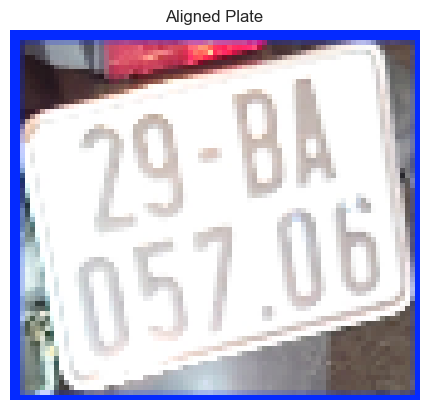

In [9]:
import matplotlib.pyplot as plt
import numpy as np
if plates is not None:
    aligned_plate = align_license_plate(plates)

    # Chuyển ảnh BGR (OpenCV) sang RGB (Matplotlib)
    aligned_plate_rgb = cv2.cvtColor(aligned_plate, cv2.COLOR_BGR2RGB)

    plt.imshow(aligned_plate_rgb)
    plt.axis("off")
    plt.title("Aligned Plate")
    plt.show()


In [10]:
import cv2
import numpy as np
# Hàm biến ảnh thành vuông
def convert2Square(img, size=28):

    h, w = img.shape[:2]
    max_dim = max(h, w)  # Kích thước lớn nhất để làm chuẩn

    # Tạo ảnh vuông có nền đen
    square_img = np.zeros((max_dim, max_dim), dtype=np.uint8)

    # Canh giữa ký tự trong ảnh vuông
    y_offset = (max_dim - h) // 2
    x_offset = (max_dim - w) // 2
    square_img[y_offset:y_offset + h, x_offset:x_offset + w] = img

    # Resize về 28x28
    final_img = cv2.resize(square_img, (size, size), interpolation=cv2.INTER_AREA)

    return final_img


In [11]:
import cv2
import numpy as np
from skimage import measure
from skimage.filters import threshold_local
import imutils

# Phân đoạn ký tự
def segment_characters(aligned_plate):
    # Bước 1: Chuyển sang không gian màu HSV và lấy kênh V (độ sáng)
    V = cv2.split(cv2.cvtColor(aligned_plate, cv2.COLOR_BGR2HSV))[2]

    # Bước 2: Áp dụng adaptive threshold
    T = threshold_local(V, 15, offset=10, method="gaussian")
    thresh = (V > T).astype("uint8") * 255
    # cv2.imshow("Adaptive Threshold", thresh)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Bước 3: Đảo màu chữ trắng, nền đen
    thresh = cv2.bitwise_not(thresh)

    # Bước 4: Resize ảnh để thống nhất kích thước xử lý
    thresh = imutils.resize(thresh, width=400)

    # Bước 5: Làm mờ ảnh để giảm nhiễu
    thresh = cv2.medianBlur(thresh, 5)
    # cv2.imshow("Bitwise", thresh)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Bước 6: Phân tích thành phần liên kết (Connected Components)
    labels = measure.label(thresh, connectivity=2, background=0)
    candidates = []  # Danh sách lưu cặp (ảnh, tọa độ)

    for label in np.unique(labels):
        if label == 0:
            continue

        # tạo mask chỉ chứa thành phần hiện tại
        mask = np.zeros(thresh.shape, dtype="uint8")
        mask[labels == label] = 255

        # tìm contour của thành phần
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            (x, y, w, h) = cv2.boundingRect(contour)

            # lọc bỏ các vùng không phải ký tự
            aspectRatio = w / float(h)
            solidity = cv2.contourArea(contour) / float(w * h)
            heightRatio = h / float(aligned_plate.shape[0])

            if 0.1 < aspectRatio < 1.0 and solidity > 0.1 and 0.35 < heightRatio < 2.0:
                char_img = mask[y:y + h, x:x + w]
                char_img = convert2Square(char_img, size=28)
                char_img = char_img.reshape((28, 28, 1))
                candidates.append((char_img, (y, x)))

    candidates = sorted(candidates, key=lambda c: c[1][1])
    return candidates

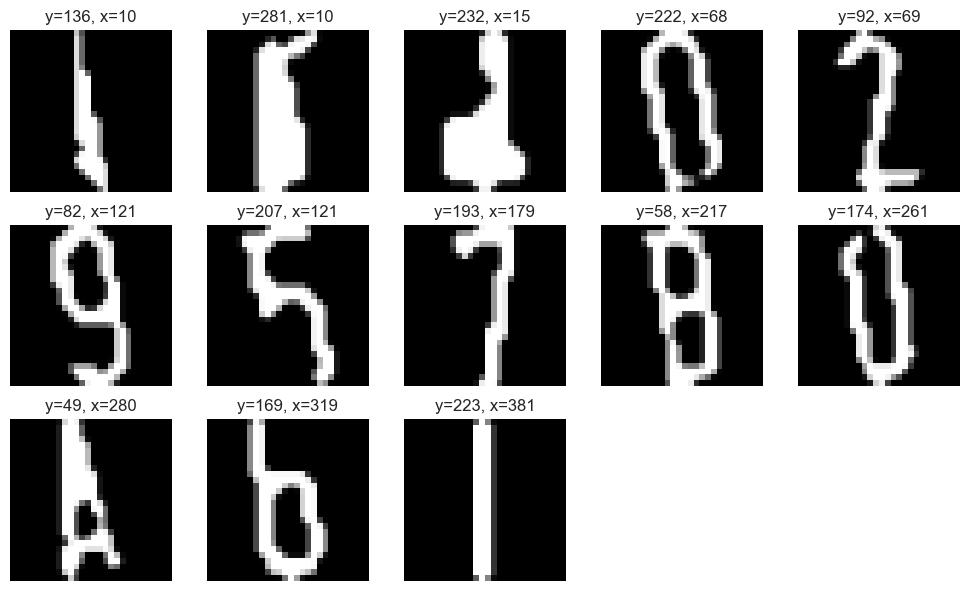

In [12]:
import matplotlib.pyplot as plt
import numpy as np

characters = segment_characters(aligned_plate)  # Phân đoạn ký tự

if not characters:  # Kiểm tra nếu None hoặc rỗng
    print("Không tìm thấy ký tự nào trên biển số.")
else:
    cols = 5  # Cố định số cột
    rows = (len(characters) + cols - 1) // cols  # Tính số hàng đủ để chứa ký tự

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()  # Chuyển thành danh sách truy cập dễ dàng

    for i, (char_img, (y, x)) in enumerate(characters):
        axes[i].imshow(char_img, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(f"y={y}, x={x}")

    # Ẩn các ô trống nếu số ký tự không đủ hàng x cột
    for i in range(len(characters), len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


In [24]:
import os
import cv2


# output_folder = "./Traning-cnn/segment-char/29A-23336"
# output_folder = "./Traning-cnn/segment-char/61LD-02896"
output_folder = "./Traning-cnn/segment-char/29AA-87148"
os.makedirs(output_folder, exist_ok=True)

characters = segment_characters(aligned_plate)

for i, (char_img, (y, x)) in enumerate(characters):
    filename = os.path.join(output_folder, f"char_{i+1}.png")
    cv2.imwrite(filename, char_img)
    print(f"Saved {filename}")

Saved ./Traning-cnn/segment-char/29AA-87148\char_1.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_2.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_3.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_4.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_5.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_6.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_7.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_8.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_9.png
Saved ./Traning-cnn/segment-char/29AA-87148\char_10.png


In [13]:
import numpy as np
from tensorflow.keras.models import load_model

# ALPHA_DICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
#               10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L',
#               20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y',
#               30: 'Z', 31: 'Background'}
ALPHA_DICT = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'Background', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H',
    19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'P', 24: 'R', 25: 'S', 26: 'T', 27: 'U',
    28: 'V', 29: 'X', 30: 'Y', 31: 'Z'}

class LicensePlateRecognizer:
    def __init__(self, model_path):
        self.recogChar = load_model(model_path)
        self.candidates = []

    def recognize_characters(self, candidates):
        if not candidates:
            print("Khong co ki tu nao duoc nhan dien.")
            return []

        characters = np.array([char for char, _ in candidates]) / 255.0  # Chuẩn hóa pixel
        coordinates = [coord for _, coord in candidates]

        # Nhận diện ký tự
        results = self.recogChar.predict_on_batch(characters)
        result_idx = np.argmax(results, axis=1)

        # Lưu lại các ký tự nhận diện được
        recognized_chars = [(ALPHA_DICT[idx], coord) for idx, coord in zip(result_idx, coordinates) if idx != 12]
        self.candidates = recognized_chars

    def get_recognized_text(self):
        if not self.candidates:
            return ""

        return "".join([char for char, _ in sorted(self.candidates, key=lambda x: x[1][1])])  # Sắp xếp theo x

    def format(self):
        if not self.candidates:
            return ""

        # Xác định giá trị y trung bình
        y_values = [coord[0] for _, coord in self.candidates]
        y_mean = np.mean(y_values)

        first_line, second_line = [], []
        for char, coord in self.candidates:
            if coord[0] < y_mean:  # Nếu y nhỏ hơn trung bình => dòng trên
                first_line.append((char, coord[1]))  # Lưu theo x
            else:
                second_line.append((char, coord[1]))

        # Sắp xếp từ trái sang phải theo x
        first_line.sort(key=lambda s: s[1])
        second_line.sort(key=lambda s: s[1])

        if not second_line:
            return "".join([char for char, _ in first_line])
        else:
            return "".join([char for char, _ in first_line]) + "-" + "".join([char for char, _ in second_line])




In [14]:
# --- Sử dụng ---
model_path = "./Traning-cnn/cnn/model/license_plate_char_pro_max.h5"
recognizer = LicensePlateRecognizer(model_path)

# Gọi phân đoạn ký tự trước
# candidates = segment_characters(aligned_plate)

# Nhận diện ký tự
recognizer.recognize_characters(characters)
plate_number = recognizer.format()

print("Biển số xe:", plate_number)

Biển số xe: 29BA-05706
